## PROJECT SUMMARY

### PROJECT: Top 10 Economies by GDP - 2024 & 2030 Forecasting

**INTRODUCTION**



### 01. Environment Setting

In [1]:
#Libraries
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import os
import sys


#Custom Libraries
sys.path.append('../')
#from src import eda_aux as eda

#Parameters
plt.rcParams.update({'font.size': 8})

In [2]:
##--Work_directory
wd_data = os.getcwd().replace(os.getcwd().split("\\")[-1],'') + '/models/'
wd_data

'c:\\Users\\jrab9\\OneDrive\\08.Github\\2023_WDI_ts_GDP_forecasting\\/models/'

### 02. Data

In [3]:
###--Countries
dim_country = pd.read_csv(os.getcwd().replace(os.getcwd().split("\\")[-1],'') + '/data/final/dim_country.csv.gz')

###--Values
files = os.listdir(wd_data + '/data/raw/')

df = pd.DataFrame()

for f in files:
    df_temp = pd.read_csv(wd_data + '/data/raw/' + f)
    df_temp['model'] = f
    df_temp.loc[df_temp['tts_flag'] == 'Predict',['level','target']] = df_temp['y_pred'] #Getting pred for predict in target to compare evol
    df = pd.concat([df,df_temp])

df['model'] = df['model'].str.split('_').str[1].str.replace('.csv.gz','')
df['key'] = df['country_iso3'] + '-' + df['model'] + '-' + df['exp']

df = df.merge(dim_country[['iso3','name']], how = 'left', left_on = 'country_iso3', right_on = 'iso3').drop(columns = 'iso3')

countries = df.country_iso3.unique()

##Units
df[['level','target','y_pred']] = np.round(df[['level','target','y_pred']] / 1000000000,2)

test_min = df[df['tts_flag'] == 'Test']['time'].min()
test_max = df[df['tts_flag'] == 'Test']['time'].max()

df.head()


,time,country_iso3,level,target,tts_flag,y_pred,exp,model,key,name
0,1994,AUS,322.80,322.80,Train,322.80,"4,1,5",ARIMA,"AUS-ARIMA-4,1,5",Australia
1,1995,AUS,368.17,368.17,Train,368.17,"4,1,5",ARIMA,"AUS-ARIMA-4,1,5",Australia
2,1996,AUS,401.34,401.34,Train,401.34,"4,1,5",ARIMA,"AUS-ARIMA-4,1,5",Australia
3,1997,AUS,435.64,435.64,Train,435.64,"4,1,5",ARIMA,"AUS-ARIMA-4,1,5",Australia
4,1998,AUS,399.67,399.67,Train,399.67,"4,1,5",ARIMA,"AUS-ARIMA-4,1,5",Australia


In [4]:
###--- Results
files = os.listdir(wd_data + '/summary/raw/')

df_sum = pd.DataFrame()

for f in files:
    df_temp = pd.read_csv(wd_data + '/summary/raw/' + f)
    df_temp['model'] = f
    df_sum = pd.concat([df_sum,df_temp])

df_sum['model'] = df_sum['model'].str.split('_').str[1].str.replace('.csv.gz','')

###-- Getting only lower MAPE
selected_models = pd.DataFrame()

for c_code in countries:
    df_temp = df_sum.loc[df_sum['country_iso3'] == c_code,:]   
    for model in df_temp.model.unique():                    
        df_temp_ = df_temp.loc[df_temp['model'] == model,:]     

        df_temp_ = df_temp_.loc[df_temp_['mape'] == min(df_temp_.mape)]
        df_temp_.reset_index(drop = True, inplace = True)
        df_temp_['key'] = df_temp_['country_iso3'] + '-' + df_temp_['model'] + '-' + df_temp_['exp']

        selected_models = pd.concat([selected_models, df_temp_[['country_iso3','model','mape','exp','key']]])

selected_models.head()

,country_iso3,model,mape,exp,key
0,AUS,ARIMA,0.502944,"4,1,5","AUS-ARIMA-4,1,5"
0,AUS,HOWI,0.082747,"s_level:0.5, s_trend:0.85, s_seasonal:0.95, tr...","AUS-HOWI-s_level:0.5, s_trend:0.85, s_seasonal..."
0,BRA,ARIMA,0.314999,"5,1,1","BRA-ARIMA-5,1,1"
0,BRA,HOWI,0.091951,"s_level:0.7, s_trend:0.95, s_seasonal:0.2, tre...","BRA-HOWI-s_level:0.7, s_trend:0.95, s_seasonal..."
0,CAN,ARIMA,0.306959,"10,1,9","CAN-ARIMA-10,1,9"


### 03. Models

To develop the forecasting two classic statistics techniques were applied, ARIMA and Exponential Smoothing based on Holt Winters but considering 1 for the smoothing coefficients giving the possibility to apply simple and double smoothing.

The parameters optimization was done by grid search where:
1. ARIMA: The grid was built considering the ACF, PACF and the results of applying ADF to extract the integrated component.
2. Exponential Smoothing: The grid was made from 0.05 to 1.0 with a step of 0.05 and considering additive models.

For the most important countries in terms of historical values for GDP, Exponential Smoothing (HOWI) had a better performance considering as an evaluation metric the MAPE but for Japan (JPN) ARIMA was better.

The range of MAPE is extensive, reaching over 22% in testing for JPN and 3% for USA.

Even when HOWI achieved a better adjustment to he variations on the curves, neither of the models made good adjustments to the originals during the Test, each series given its clear differences should be analyzed deeper individually and other techniques should be tested to reach better results.


In [5]:
##--Models summary
arimahowi = selected_models[selected_models['country_iso3'].isin(selected_models[selected_models['model'] == 'HOWI']['country_iso3'])].pivot(index = 'country_iso3', columns = 'model', values = 'mape').reset_index()
arimahowi['lower_mape'] = np.where(arimahowi['ARIMA'] < arimahowi['HOWI'], arimahowi['ARIMA'], arimahowi['HOWI'])
arimahowi['selected_model'] = np.where(arimahowi['ARIMA'] < arimahowi['HOWI'], 'ARIMA', 'HOWI')
arimahowi['%_mape_gain'] = np.round((np.where(arimahowi['ARIMA'] < arimahowi['HOWI'], arimahowi['ARIMA'] , arimahowi['HOWI'] ) - np.where(arimahowi['ARIMA'] < arimahowi['HOWI'], arimahowi['HOWI'], arimahowi['ARIMA'] )) * 100,1)
arimahowi.sort_values('%_mape_gain', ascending = True)

model,country_iso3,ARIMA,HOWI,lower_mape,selected_model,%_mape_gain
6,FIN,0.951757,0.072724,0.072724,HOWI,-87.9
17,USA,0.754783,0.018127,0.018127,HOWI,-73.7
3,CHN,0.557393,0.033276,0.033276,HOWI,-52.4
10,IND,0.549310,0.026802,0.026802,HOWI,-52.3
0,AUS,0.502944,0.082747,0.082747,HOWI,-42.0
16,SAU,0.458438,0.088889,0.088889,HOWI,-37.0
5,ESP,0.379504,0.060168,0.060168,HOWI,-31.9
14,MEX,0.368254,0.060739,0.060739,HOWI,-30.8
9,IDN,0.314053,0.024192,0.024192,HOWI,-29.0
7,FRA,0.343078,0.062847,0.062847,HOWI,-28.0


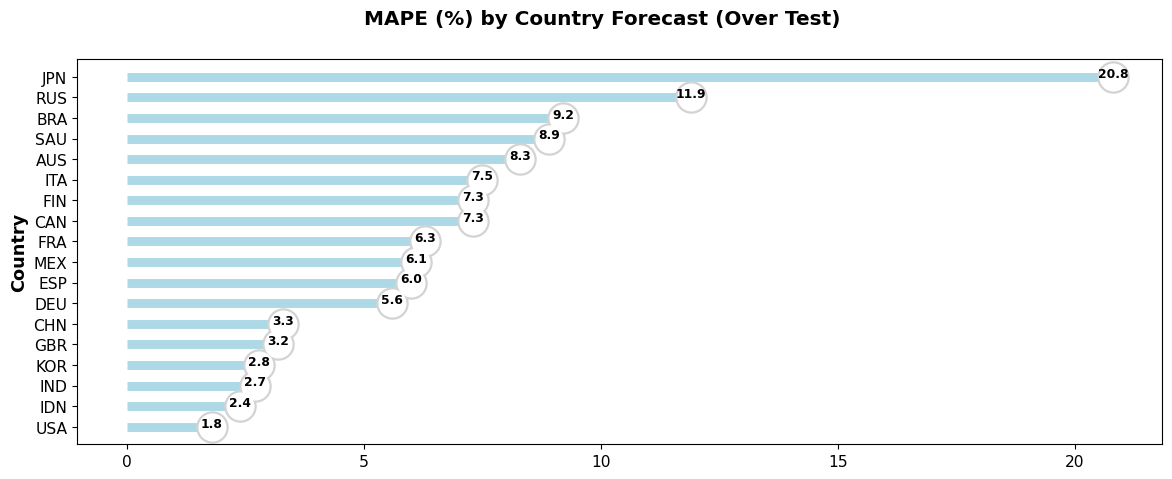

In [6]:
##--Plotting best performance (MAPE)
scale = 0.8
titleSize = 18 * scale
subtitleSize = 14 * scale
sublabelSize = 14 * scale
outerMarkerSize = 28 * scale
innerMarkerSize = 24 * scale
annotSize = 11 * scale
labelFontSize = 16 * scale

metricaplt = 'lower_mape'
ordered_df = arimahowi.sort_values('lower_mape', ascending = True)
ordered_df[metricaplt] = np.round(ordered_df[metricaplt] * 100, 1)
rangoplt = ordered_df['country_iso3'].unique()

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 5))
fig.suptitle('MAPE (%) by Country Forecast (Over Test)',fontweight="bold", size=titleSize)

#Plotting
ax1.hlines(y= ordered_df['country_iso3'], xmin=0, xmax=ordered_df[metricaplt], color='lightblue', linewidth=8 * scale)
ax1.plot(ordered_df[metricaplt], rangoplt , "o", markersize=outerMarkerSize, color = 'lightgray')
ax1.plot(ordered_df[metricaplt], rangoplt , "o", markersize=innerMarkerSize, color = 'white')
ax1.set_ylabel('Country',fontweight="bold", fontsize = labelFontSize)
ax1.tick_params(axis='x', labelsize=sublabelSize)
ax1.tick_params(axis='y', labelsize=sublabelSize)

for country in rangoplt:
    ax1.annotate(round(ordered_df[ordered_df['country_iso3'] == country][metricaplt].values[0],1), 
                 (ordered_df[ordered_df['country_iso3'] == country][metricaplt].values[0],
                  ordered_df[ordered_df['country_iso3'] == country].country_iso3.values[0]), 
                 textcoords='offset pixels', 
                 xytext=(0,0), 
                 ha='center',
                 fontsize= annotSize,fontweight="bold")

Both techniques weren't efficient in terms of fixing the volatility or changes in the series, where HOWI only reached logic values in 2024, this can mean that the configuration of parameters or transformations in the given series wasn't enough to detect in long-term patterns, considering that the forecasting was done using a recursive approach by each predicted value.

The FIN (Finland values) are not logic, the ARIMA model is taking an exponential behavior.

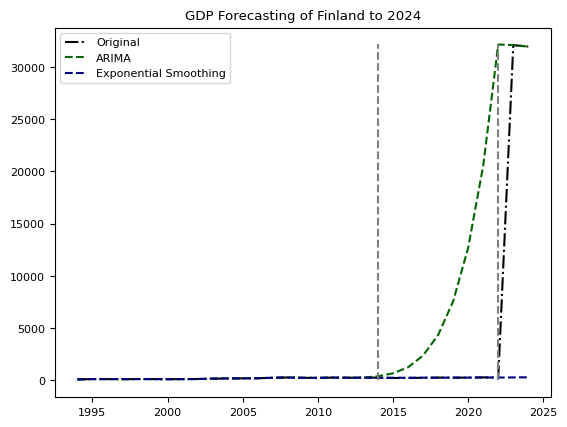

In [25]:
##--Exploring
min_year = 1994
max_year = 2024

df_part = df[(df['country_iso3'] == 'FIN') & (df['time'] >= min_year) & (df['time'] <= max_year)]

grx_x = df_part.sort_values('time').time.unique()
grx_y_ori = df_part.loc[df_part['model'] == 'ARIMA','level']#.reset_index(drop = True)
grx_y_ari = df_part.loc[df_part['model'] == 'ARIMA','y_pred']#.reset_index(drop = True)
grx_y_how = df_part.loc[df_part['model'] == 'HOWI','y_pred']#.reset_index(drop = True)

plt.plot(grx_x, grx_y_ori, color = 'black', linestyle = '-.', label = 'Original')
plt.plot(grx_x, grx_y_ari, color = 'darkgreen', linestyle = '--', label = 'ARIMA')
plt.plot(grx_x, grx_y_how, color = 'navy', linestyle = '--', label = 'Exponential Smoothing')
    
plt.title(f'GDP Forecasting of Finland to {max_year}')
plt.legend()

plt.vlines(x = test_min, ymin = 0, ymax = max(grx_y_ari), linestyle = '--', color = 'grey')
plt.vlines(x = test_max, ymin = 0, ymax = max(grx_y_ari), linestyle = '--', color = 'grey')
plt.show()

In [26]:
##--TOP 10 GDP's with ARIMA
display(df[(df['model'] == 'ARIMA') & (df['time'] == df['time'].max())].sort_values('y_pred', ascending = False).head(11)[['time','country_iso3','name','y_pred','model']])
print('Top 10 GDPs by 2030 using ARIMA models')

,time,country_iso3,name,y_pred,model
261,2030,CHN,China,31821.58,ARIMA
1311,2030,USA,United States,27911.56,ARIMA
486,2030,FIN,Finland,19930.54,ARIMA
1161,2030,RUS,Russian Federation,5692.17,ARIMA
336,2030,DEU,Germany,5180.73,ARIMA
36,2030,AUS,Australia,4477.68,ARIMA
936,2030,JPN,Japan,4188.01,ARIMA
786,2030,IND,India,4124.88,ARIMA
636,2030,GBR,United Kingdom,3955.28,ARIMA
561,2030,FRA,France,3891.14,ARIMA


Top 10 GDPs by 2030 using ARIMA models


In [8]:
##--TOP 10 GDP's with Exponential Smoothing
display(df[(df['model'] == 'HOWI') & (df['time'] == 2024)].sort_values('y_pred', ascending = False).head(10)[['time','name','y_pred','model']])
print('Top 10 GDPs by 2024 using HOWI models')

,time,name,y_pred,model
1343,2024,United States,23046.67,HOWI
293,2024,China,12998.63,HOWI
968,2024,Japan,5289.72,HOWI
368,2024,Germany,4368.67,HOWI
668,2024,United Kingdom,4029.79,HOWI
593,2024,France,3508.80,HOWI
893,2024,Italy,2913.57,HOWI
818,2024,India,2697.15,HOWI
143,2024,Brazil,2586.97,HOWI
218,2024,Canada,2336.18,HOWI


Top 10 GDPs by 2024 using HOWI models


In [9]:
##--TOP 10 GDP's with best models based on MAPE values
arimahowi['country_model'] = arimahowi['country_iso3'] + '-' + arimahowi['selected_model']
df['country_model'] = df['country_iso3'] + '-' + df['model']

df_temp = df.loc[df['country_model'].isin(arimahowi['country_model'].unique()),:].reset_index(drop = True)

top_12 = df_temp[df_temp['time'] == 2024].sort_values('y_pred', ascending = False).head(12)[['time','country_iso3','name','y_pred','model']]

df_temp = df_temp[df_temp['country_iso3'].isin(top_12['country_iso3'])]

display(top_12)
print('Top 10 GDPs by 2024 using best models')

,time,country_iso3,name,y_pred,model
677,2024,USA,United States,23046.67,HOWI
145,2024,CHN,China,12998.63,HOWI
487,2024,JPN,Japan,5289.72,HOWI
183,2024,DEU,Germany,4368.67,HOWI
335,2024,GBR,United Kingdom,4029.79,HOWI
297,2024,FRA,France,3508.80,HOWI
449,2024,ITA,Italy,2913.57,HOWI
411,2024,IND,India,2697.15,HOWI
69,2024,BRA,Brazil,2586.97,HOWI
107,2024,CAN,Canada,2336.18,HOWI


Top 10 GDPs by 2024 using best models


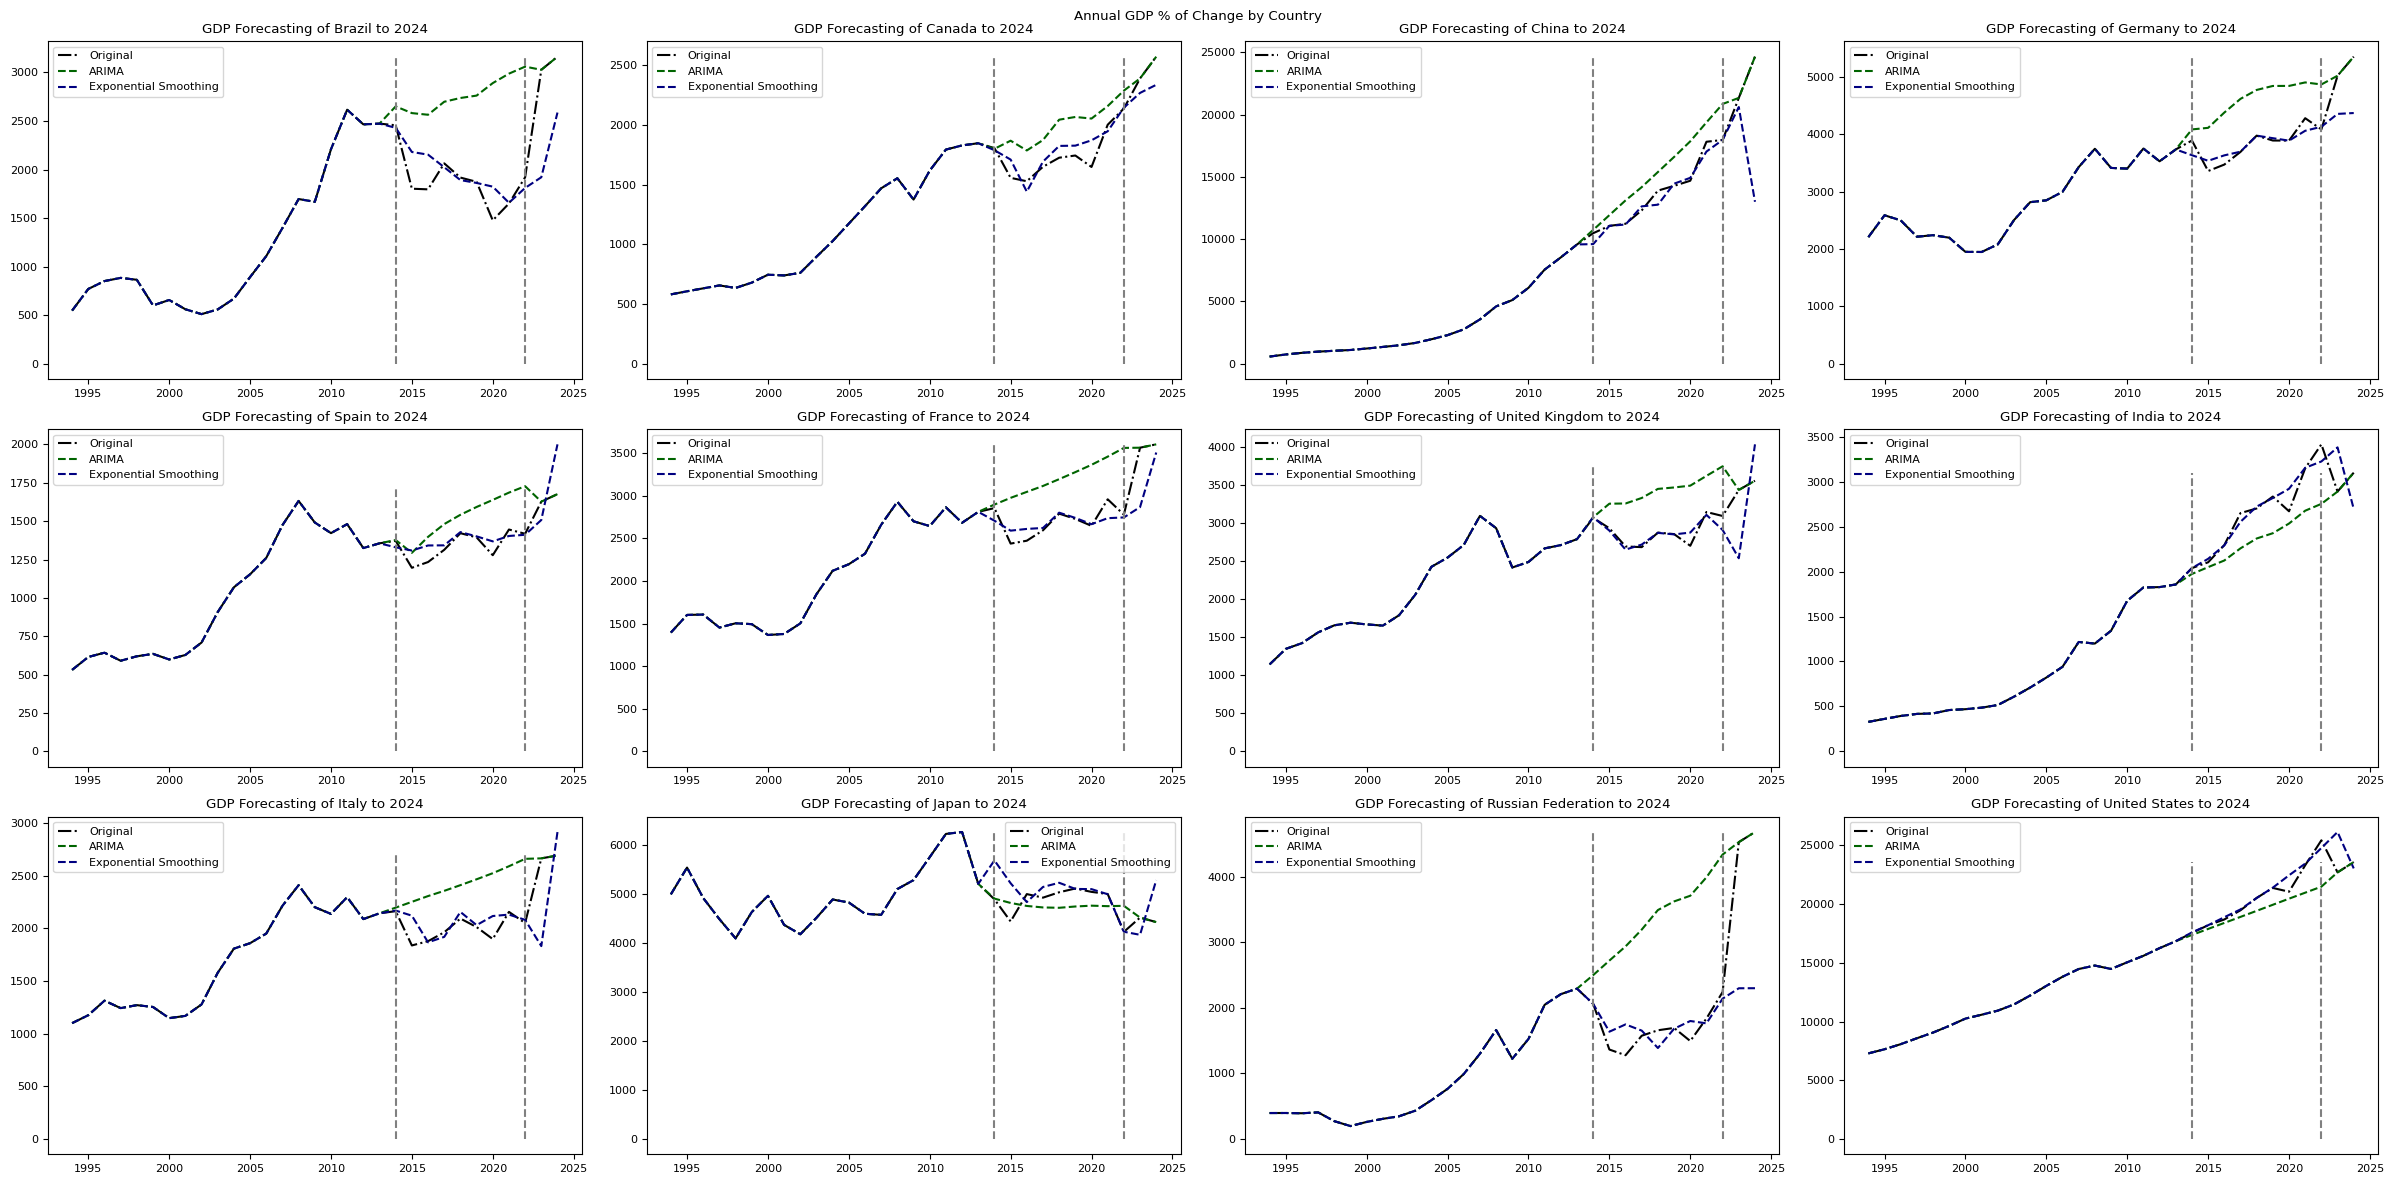

In [15]:
##--Exploring
min_year = 1994
max_year = 2024

aux_a = df_temp['name'].unique()

numberOfPlots = len(aux_a)
numberOfCols = 4 if numberOfPlots >= 4 else int(numberOfPlots)
numberOfRows = int(np.ceil(numberOfPlots / numberOfCols))

figShapeHeight = numberOfRows * 4
figShapeWidth = numberOfCols * 6

def series_grx(ax, df_part, max_year, min_year, test_min, test_max, ARIMA = True, HOWI = True):   
    df_part = df_part.loc[(df_part['time'] <= max_year) & (df_part['time'] >= min_year),:]
    
    c_name = df_part['name'].unique()[0]

    grx_x = df_part.sort_values('time').time.unique()
    grx_y_ori = df_part.loc[df_part['model'] == 'ARIMA','level']#.reset_index(drop = True)
    grx_y_ari = df_part.loc[df_part['model'] == 'ARIMA','y_pred']#.reset_index(drop = True)
    grx_y_how = df_part.loc[df_part['model'] == 'HOWI','y_pred']#.reset_index(drop = True)

    ax.plot(grx_x, grx_y_ori, color = 'black', linestyle = '-.', label = 'Original')
    if ARIMA:
        ax.plot(grx_x, grx_y_ari, color = 'darkgreen', linestyle = '--', label = 'ARIMA')
    if HOWI:
        ax.plot(grx_x, grx_y_how, color = 'navy', linestyle = '--', label = 'Exponential Smoothing')
        
    ax.set_title(f'GDP Forecasting of {c_name} to {max_year}')

    ax.vlines(x = test_min, ymin = 0, ymax = max(grx_y_ari), linestyle = '--', color = 'grey')
    ax.vlines(x = test_max, ymin = 0, ymax = max(grx_y_ari), linestyle = '--', color = 'grey')

fig, axes = plt.subplots(nrows=numberOfRows, ncols=numberOfCols, sharey=False, sharex=False, figsize=(figShapeWidth, figShapeHeight))
fig.suptitle('Annual GDP % of Change by Country')

for country, ax in zip(range(numberOfPlots), axes.flatten()):
    c_code = df_temp['country_iso3'].unique()[country]
    df_part = df[df['country_iso3'] == c_code].reset_index(drop = True).sort_values('time')    
    series_grx(ax = ax, df_part = df_part, max_year = max_year, min_year = min_year, test_max = test_max, test_min = test_min)
    ax.legend()

plt.tight_layout()
plt.show()

In [11]:
##--Changes in range
df_change = df[(df['model'] == 'ARIMA') & (df['time'].isin([2014,2022,2030]))].sort_values('y_pred', ascending = False)[['time','name','target']].pivot(index = 'name', columns = 'time', values ='target').reset_index().copy()
df_change.columns = ['country','gdp_2014','gdp_2022','gdp_2023']
df_change['%oChange_14_22'] = np.round((df_change['gdp_2022'] - df_change['gdp_2014'] ) / df_change['gdp_2014'] * 100 , 2)
df_change['%oChange_22_30'] = np.round((df_change['gdp_2023'] - df_change['gdp_2022'] ) / df_change['gdp_2022'] * 100 , 2)
df_change.sort_values('gdp_2023', ascending = False).head(12).reset_index(drop = True)

,country,gdp_2014,gdp_2022,gdp_2023,%oChange_14_22,%oChange_22_30
0,China,10475.62,17963.17,31821.58,71.48,77.15
1,United States,17550.68,25439.70,27911.56,44.95,9.72
2,Finland,274.86,282.90,19930.54,2.93,6945.08
3,Russian Federation,2059.24,2240.42,5692.17,8.80,154.07
4,Germany,3889.09,4082.47,5180.73,4.97,26.90
5,Australia,1468.60,1692.96,4477.68,15.28,164.49
6,Japan,4896.99,4232.17,4188.01,-13.58,-1.04
7,India,2039.13,3416.65,4124.88,67.55,20.73
8,United Kingdom,3064.71,3089.07,3955.28,0.79,28.04
9,France,2855.96,2779.09,3891.14,-2.69,40.01


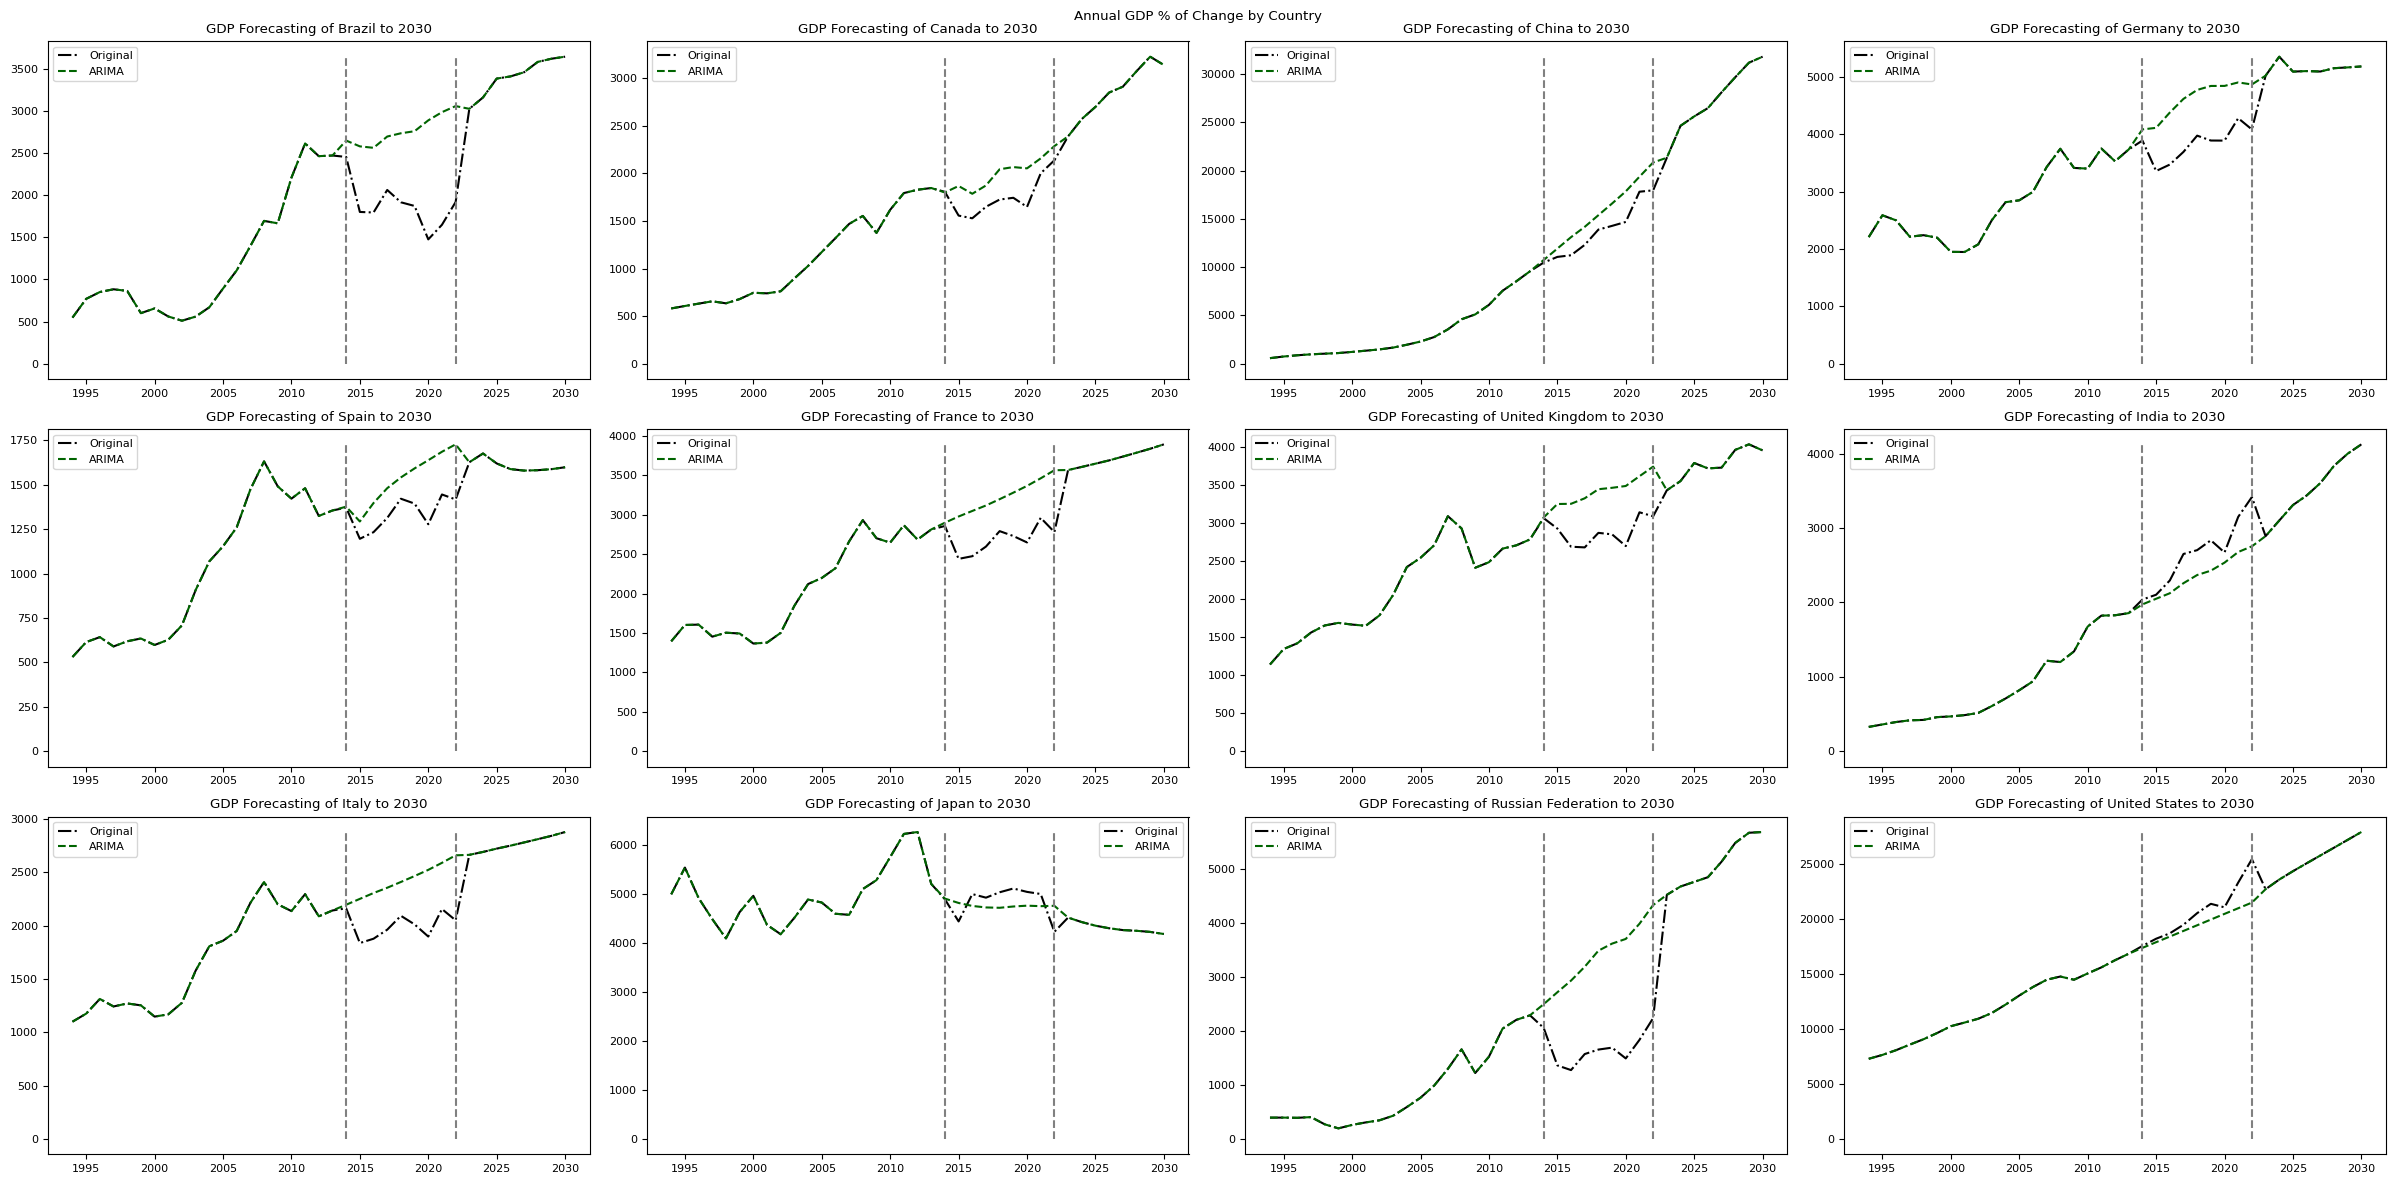

In [12]:
##--Exploring
min_year = 1994
max_year = 2030

fig, axes = plt.subplots(nrows=numberOfRows, ncols=numberOfCols, sharey=False, sharex=False, figsize=(figShapeWidth, figShapeHeight))
fig.suptitle('Annual GDP % of Change by Country')

for country, ax in zip(range(numberOfPlots), axes.flatten()):
    c_code = df_temp['country_iso3'].unique()[country]
    df_part = df[df['country_iso3'] == c_code]
    series_grx(ax, df_part, max_year, min_year, HOWI = False, test_max = test_max, test_min = test_min)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
#!jupyter nbconvert --to webpdf --allow-chromium-download summary.ipynb

[NbConvertApp] Converting notebook eda.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2496199 bytes to eda.pdf
